# 4. Reporte de métricas y conclusiones

El alumno, tomando como referencia los resultados del modelo escogido en el ejercicio 3, **calculará las métricas** que permitan validar la bondad del modelo.

También incluirá **comentarios** y las conclusiones finales.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

## Obtenemos los datos guardados

In [3]:
# Comprobamos a abrirlos de nuevo
train_data = pd.read_csv("/content/drive/MyDrive/train_data_preprocesado.csv", sep=';')
test_data = pd.read_csv("/content/drive/MyDrive/test_data_preprocesado.csv", sep=';')
train_data.shape, test_data.shape

((800, 2), (200, 2))

In [4]:
def save_pkl(model_name, model):
  # create an iterator object with write permission - model.pickle
  with open(model_name, 'wb') as files:
    pickle.dump(model, files)

In [5]:
def load_pkl(model_name):
  # load saved model
  with open(model_name , 'rb') as f:
      lr = pickle.load(f)
  return lr

In [6]:
# obtenes la data preprocesada sin BoW
preprocessed_data = load_pkl('/content/drive/MyDrive/preprocessed_data.pkl')
preprocessed_data.keys()

dict_keys(['words_train', 'words_test', 'labels_train', 'labels_test'])

In [7]:
# obtenes las features generadas con BoW
bow_features = load_pkl('/content/drive/MyDrive/bow_features.pkl')
bow_features.keys()

dict_keys(['features_train', 'features_test', 'vocabulary'])

In [8]:
# obtenes la data utilizada para entrenar el modelo
model_features = load_pkl('/content/drive/MyDrive/model_features.pkl')
model_features.keys()

dict_keys(['x_features_train', 'y_labels_train', 'x_features_test', 'y_labels_test'])

In [9]:
# obtenes modelo
model = load_pkl('/content/drive/MyDrive/model_random_forest.pkl')
model

RandomForestClassifier(min_samples_split=8, n_estimators=28)

## Extracción de features

In [10]:
#borramos los NAN que por algún motivo se guardan en train_data
train_data = train_data.dropna()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 798 entries, 0 to 799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  798 non-null    int64 
 1   text    798 non-null    object
dtypes: int64(1), object(1)
memory usage: 18.7+ KB


In [11]:
X_train = train_data['text']
X_train.info()

<class 'pandas.core.series.Series'>
Index: 798 entries, 0 to 799
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
798 non-null    object
dtypes: object(1)
memory usage: 12.5+ KB


In [12]:
y_train = train_data['rating']
y_train.info()

<class 'pandas.core.series.Series'>
Index: 798 entries, 0 to 799
Series name: rating
Non-Null Count  Dtype
--------------  -----
798 non-null    int64
dtypes: int64(1)
memory usage: 12.5 KB


In [13]:
X_test = test_data['text']
X_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 200 entries, 0 to 199
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
200 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB


In [14]:
y_test = test_data['rating']
y_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 200 entries, 0 to 199
Series name: rating
Non-Null Count  Dtype
--------------  -----
200 non-null    int64
dtypes: int64(1)
memory usage: 1.7 KB


In [15]:
# Obtenemos la cantidad máxima de feaures
max_features = len(bow_features['vocabulary'])
max_features

918

In [16]:
# Usaremos:
# max_df=0.95, min_df=5, max_features=max_features
# No se usó ninguna métrica en especial para obtener estos valores
# solo pudimos obtener max_features ya que habiamos armado un vocabulario anteriormente

cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=max_features,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=918, min_df=5, strip_accents='ascii')

In [17]:
print(list(cv.vocabulary_.items())[:20])

[('want', 874), ('bunch', 108), ('background', 61), ('stuff', 784), ('buy', 109), ('album', 16), ('never', 536), ('even', 256), ('tune', 839), ('realli', 648), ('sound', 758), ('like', 457), ('high', 371), ('qualiti', 635), ('music', 530), ('treat', 833), ('fine', 299), ('forward', 311), ('get', 329), ('go', 336)]


In [18]:
print(len(cv.vocabulary_))

918


## TF_IDF

### TF-IDF scores

In [19]:
# Realizamos la transformación
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

### Score IDF de algunas palabras

In [20]:
words_example = [
    # algunas palabras existentes
    'album', 'never', 'ever', 'sound', 'like', 'music',
    # algunas que NO deberian existir
    'cine', 'pelicula'
]

In [21]:
vocab_idf = dict(zip(cv.get_feature_names_out(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
album               2.559
never               3.732
ever                4.316
sound               3.001
like                2.673
music               2.410
cine                OOV                 
pelicula            OOV                 


### Palabras con el TF-IDF en alguna review

In [22]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 722
Sentiment: 1
Review: thank nice hit one place


In [23]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 722:
          tfidf
place  0.537127
hit    0.483272
nice   0.466637
thank  0.436813
one    0.263413

Top 10 words with lowest TF_IDF in the review 722:
          tfidf
place  0.537127
hit    0.483272
nice   0.466637
thank  0.436813
one    0.263413


### $\chi²$ scores

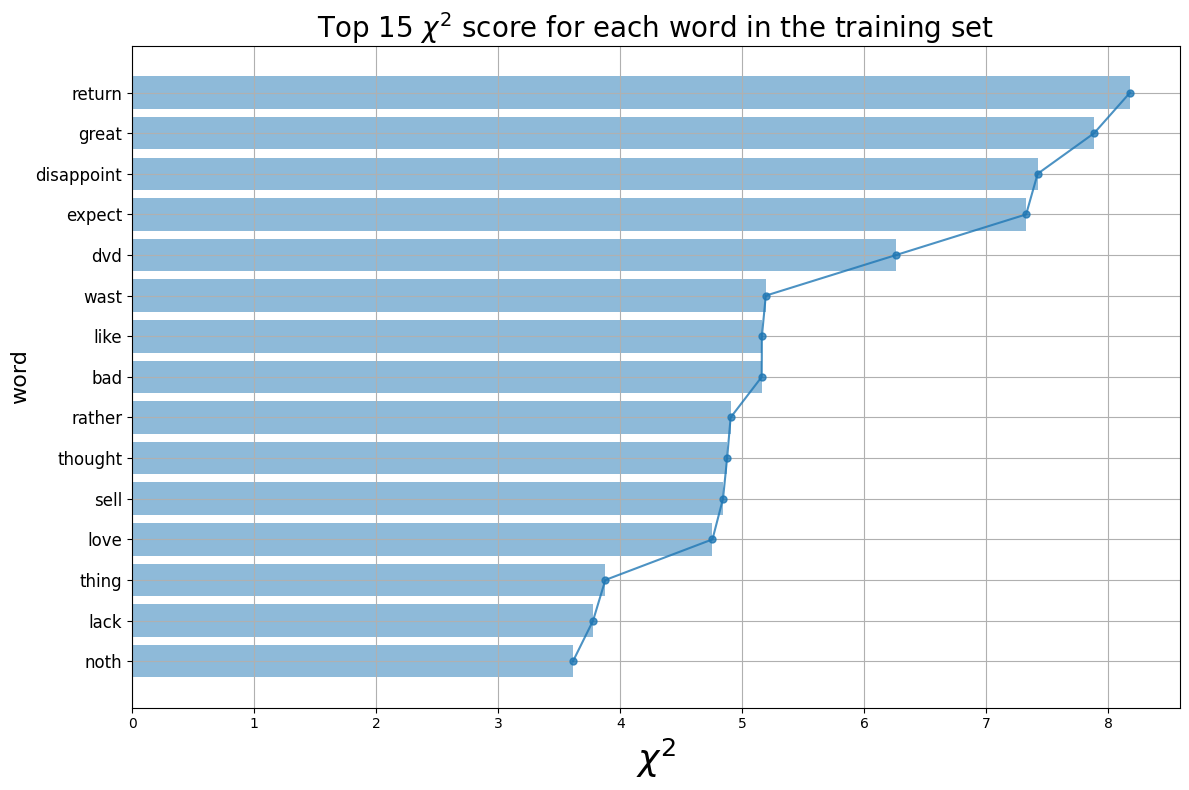

In [24]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

## Métricas Modelo Entrenado

In [25]:
# mostramos el modelo
model

RandomForestClassifier(min_samples_split=8, n_estimators=28)

In [26]:
# obtenemos las features y labels de TEST con las que se va a predecir
x_features_test = model_features['x_features_test']
y_test = model_features['y_labels_test']

In [27]:
# Creamos una predicción
test_predict = model.predict(x_features_test)

# Mostramos los resultados
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[  7  38]
 [  4 151]]

Classification report:
              precision    recall  f1-score   support

           0       0.64      0.16      0.25        45
           1       0.80      0.97      0.88       155

    accuracy                           0.79       200
   macro avg       0.72      0.56      0.56       200
weighted avg       0.76      0.79      0.74       200

Accuracy score:0.79


In [28]:
# Por lo que podemos observar el Accuracy en TEST es de 0.805
# No es un mal resultado, pero seguramente se puede mejorar

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [30]:
p, r, thresholds = precision_recall_curve(y_test, test_predict)

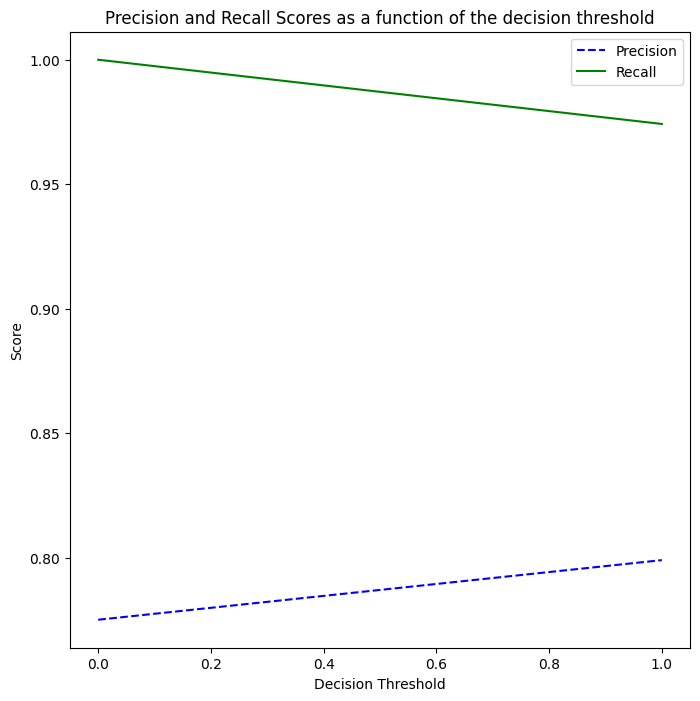

In [31]:
plot_precision_recall_vs_threshold(p, r, thresholds)

# Realizamos diversas predicciones

In [32]:
def predict_review_sentiment(df, review_index, model):
  actual = df.iloc[review_index]['rating']
  print(f'Actual sentiment: {actual}')
  r = df.iloc[review_index]['text']
  prediction = model.predict(cv.transform([r]))
  icon =  '✅' if prediction == actual else '❌'
  print(f'Prediction: {prediction} {icon}')

In [33]:
df = test_data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  200 non-null    int64 
 1   text    200 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [34]:
for i in random.sample(range(0, len(df)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(df, i, model)


Review no. 30
Actual sentiment: 1
Prediction: [1] ✅

Review no. 197
Actual sentiment: 1
Prediction: [1] ✅

Review no. 62
Actual sentiment: 1
Prediction: [0] ❌

Review no. 134
Actual sentiment: 1
Prediction: [1] ✅

Review no. 2
Actual sentiment: 1
Prediction: [1] ✅

Review no. 76
Actual sentiment: 0
Prediction: [1] ❌

Review no. 140
Actual sentiment: 1
Prediction: [1] ✅

Review no. 35
Actual sentiment: 1
Prediction: [0] ❌

Review no. 87
Actual sentiment: 0
Prediction: [0] ✅

Review no. 161
Actual sentiment: 1
Prediction: [1] ✅


## Conclusión Final

Partimos de un dataset desbalanceado.

Realizamos un agrupamiento binario, donde las reviews positivas agrupaban los valores 4 y 5 y las reviews negativas el resto.

Rebalanceamos el dataset y realizamos un análisis exploratorio.
Aqui nos pudimos dar cuenta que hay muchas palabras comunes tanto para las reviews positivas como para las negativas. En un principio se pensó que esto podría perjudicar la predicción, pero realmente no se noto (esto se vió luego de entrenar el modelo, que se realiza más adelante).

Luego pasamos a realizar un preprocesamiento del texto, pero como teníamos muchos registros, el análisis completo iba a demorar mucho tiempo y se tuvo que reducir drásticamente el tamaño a preprocesar.
Solo dejamos 800 filas para train y 200 filas para test.

Como tercer paso se armo el BoW y se realizaron pruebas con diferentes modelos de clasificación.
Dicha prueba sirvió para elegir el modelo final a entrenar, que en este caso fue Random Forest.
Al mismo se le eligieron algunos hiperparámetros óptimos.
El accuracy para el entrenamiento grupal de random forest nos dio 0.798, pero luego con los hiperparámetros óptimos logro en **train** un accuracy de **0.98** (quizas sea overfitting) y para **test** un accuracy de **0.79**

Como cuarto paso, con todos los diferentes datos procesados con anterioridad, pasamos a analizar el TD-IDF y el Chi2.

Para terminar, generamos métricas para el modelo final de Random Forest, un gráfico de precission y recall,  y culminamos armando diferentes predicciones para ver como se comportaba el modelo.

Por lo que pudimos ver el modelo se comporta bastante bien. Quizas se podría llegar a mejorar buscando un modelo que tenga un accuracy menor al 0.99 en train.
También el problema de de un accuracy no muy alto en test puede venir por otro lado, ya que puede ser algo que falte o se esté realizando mal al normalizar los datos. Por ejemplo sacando palabras comunes.

Por el momento cualquier cambio que sirva para mejorar la predicción queda fuera de alcance por una cuestión de tiempo.